In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
from app import *
from sqlalchemy import inspect
import seaborn as sns
import plotly.graph_objects as go
import time
from datetime import datetime
import calmap
from matplotlib.dates import MO, WeekdayLocator
from scipy import interpolate

pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 500)

In [3]:
def object_as_dict(results):
    dict_result = []

    for result in results:
        new_row = {
            c.key: getattr(result, c.key) for c in inspect(result).mapper.column_attrs
        }
        dict_result.append(new_row)

    df = pd.DataFrame(dict_result)
    return df

filter = {}
filter = {'game_mode': 22, 'lobby_type': 7}

matches = PlayerMatches().query.filter_by(game_mode = 22, lobby_type=7).all()

df = object_as_dict(matches)

heroes = Heroes().query.all()
temp_df = object_as_dict(heroes)
map_df_heroes = temp_df[["hero_id", "localized_name"]]
mapping_dict = dict(zip(map_df_heroes.hero_id, map_df_heroes.localized_name))
df["hero_name"] = df["hero_id"].map(mapping_dict)

df_first_session = df.sort_values(['start_time'], ascending=True).groupby('session_id').first().reset_index()
df_first_session['day_of_week'] = df_first_session['start_time_normal'].dt.day_name()
df['session_day_of_week'] = df['session_id'].map(dict(zip(df_first_session['session_id'], df_first_session['day_of_week'])))
df['session_start'] = df['session_id'].map(dict(zip(df_first_session['session_id'], df_first_session['start_time_normal'])))

del temp_df
del map_df_heroes
del mapping_dict
del df_first_session

In [4]:
df[['session_day_of_week', 'win']].groupby('session_day_of_week').mean().sort_values('win', ascending=False)


,win
session_day_of_week,
Thursday,0.613861
Saturday,0.607843
Tuesday,0.595506
Sunday,0.571429
Friday,0.568627
Monday,0.551282
Wednesday,0.481481


             hero_name       win  times_played
31                Mars  0.000000             3
57     Vengeful Spirit  0.000000             2
50              Tinker  0.000000             1
38       Queen of Pain  0.000000             1
35    Nature's Prophet  0.000000             2
33               Meepo  0.000000             1
18       Dragon Knight  0.000000             1
13         Dark Willow  0.000000             1
12           Dark Seer  0.000000             1
63         Wraith King  0.000000             1
9                 Chen  0.000000             1
4                 Bane  0.000000             1
0            Alchemist  0.166667             6
47      Spirit Breaker  0.200000             5
45              Sniper  0.272727            11
16           Disruptor  0.300000            10
7    Centaur Warrunner  0.333333             3
52    Treant Protector  0.333333             3
25             Leshrac  0.375000             8
17                Doom  0.375000             8
19         Dr

Text(0.5, 1.0, 'Top Ten Played Heroes & Win Rate')

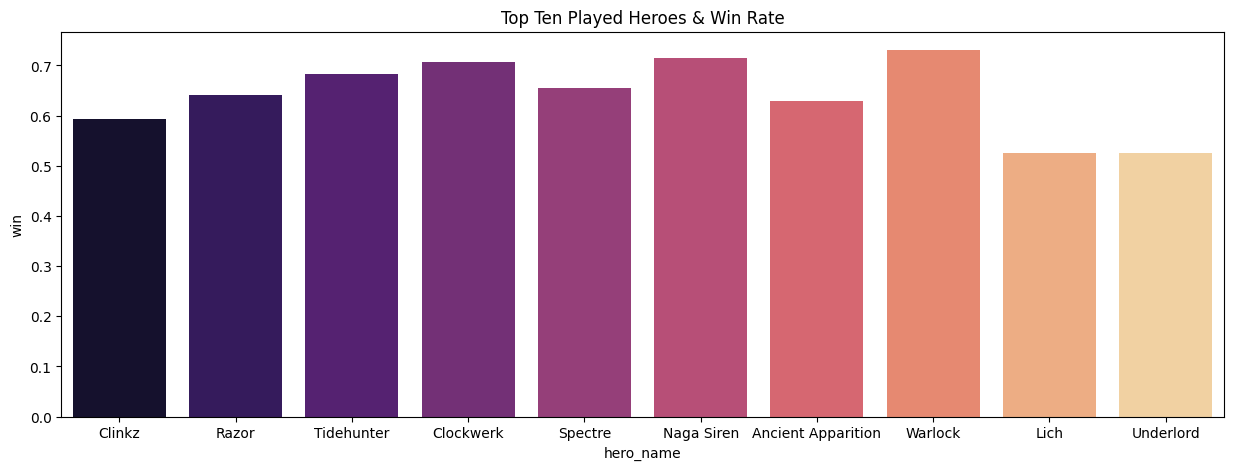

In [5]:
df_hero_wr = df[["hero_name", "win"]].copy()
df_hero_wr = df_hero_wr.groupby('hero_name').mean().reset_index()

df_hero_played = df[['hero_name']].value_counts().reset_index()
df_hero_played.columns = ['hero_name', 'times_played']
df_hero_wr = df_hero_wr.merge(df_hero_played, on='hero_name')
print(df_hero_wr.sort_values('win', ascending=True))
df_hero_wr = df_hero_wr.sort_values('times_played', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=df_hero_wr, x='hero_name', y='win', palette='magma')
plt.title('Top Ten Played Heroes & Win Rate')


             hero_name  times_played      kills    assists     deaths       KDA
10              Clinkz            54  12.796296  11.574074   5.481481  4.445946
39               Razor            50   8.200000  13.540000   6.840000  3.178363
49          Tidehunter            44   5.477273  22.068182   6.318182  4.359712
11           Clockwerk            34   4.823529  19.529412   8.764706  2.778523
46             Spectre            29   8.758621  15.551724   5.620690  4.325153
34          Naga Siren            28   7.000000  11.250000   3.357143  5.436170
1   Ancient Apparition            27   5.407407  22.407407   9.111111  3.052846
61             Warlock            26   4.384615  20.461538   7.269231  3.417989
26                Lich            19   5.473684  20.263158  10.736842  2.397059
55           Underlord            19   7.052632  20.263158   8.052632  3.392157
56                Ursa            18  13.888889   7.444444   5.055556  4.219780
14              Dazzle            16   3

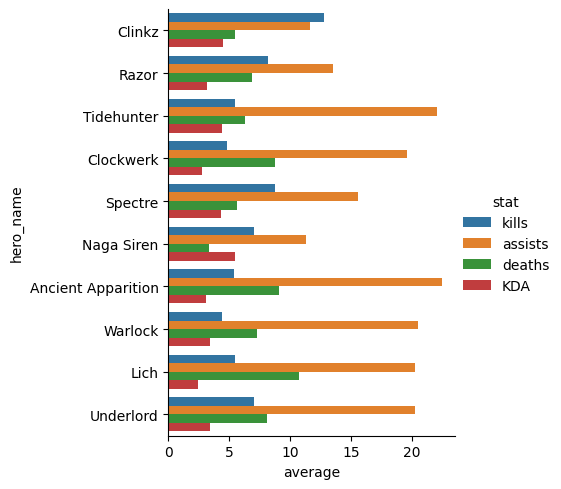

In [6]:
df_hero_stats = df[["hero_id", 'hero_name', "kills", "assists", 'deaths']].copy()
df_hero_stats = (
    df_hero_stats.groupby("hero_name", as_index=False)
    .aggregate({'hero_id': 'size', 'kills': 'mean', 'assists': 'mean', 'deaths': 'mean'})
    .sort_values("hero_id", ascending=False)
)
df_hero_stats['KDA'] = (df_hero_stats['kills'] + df_hero_stats['assists']) / df_hero_stats['deaths']
df_hero_stats.columns = ['hero_name', 'times_played', 'kills', 'assists', 'deaths', 'KDA']

print(df_hero_stats)
df_hero_stats = df_hero_stats.drop(['times_played'], axis=1).head(10)
df_hero_stats_melt = pd.melt(
    df_hero_stats, id_vars="hero_name", var_name="stat", value_name="average"
)

sns.catplot(x="average", y="hero_name", hue="stat", data=df_hero_stats_melt, kind="bar", orient='h')


(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot: ylabel='2022'>, <AxesSubplot: ylabel='2023'>],
       dtype=object))

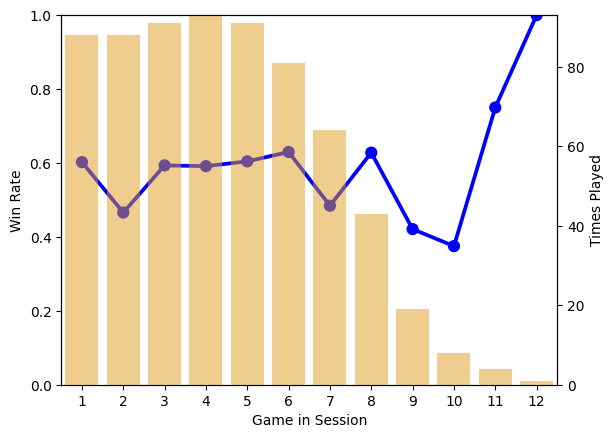

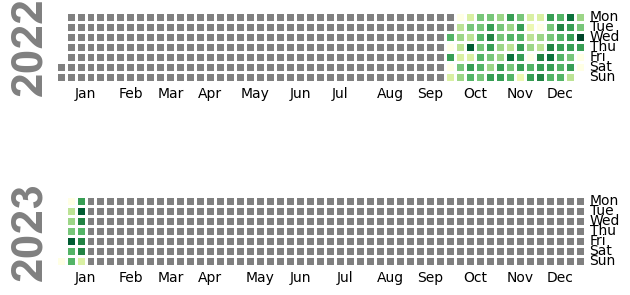

In [7]:
df_sess_mean = df[['session_counter', 'win']].groupby('session_counter').mean().reset_index()
df_sess_counter = df[['session_counter']].groupby('session_counter').value_counts().reset_index()
df_sess_mean = df_sess_mean.merge(df_sess_counter, on='session_counter')
df_sess_mean.columns = ['session_counter', 'win', 'times_played']

max_games = df_sess_mean['times_played'].max()

ax1 = sns.pointplot(
    x='session_counter', 
    y='win', 
    data=df_sess_mean,  
    color='blue'
)

ax1.set_ylabel('Win Rate')
ax1.set_ylim(0, 1)
ax1.set_xlabel("Game in Session")

ax2 = ax1.twinx()
sns.barplot(
    x='session_counter', 
    y='times_played', 
    data=df_sess_mean, 
    color='orange', 
    alpha=0.5, 
    ax = ax2
)

ax2.grid(visible=False)
ax2.set_ylabel('Times Played')
ax2.set_ylim(0, max_games)

df1 =   df['session_start'].value_counts()
calmap.calendarplot(df1, fillcolor='grey', cmap='YlGn', linewidth='0.8')


          session_start  win  loss
0   2022-09-28 18:55:17    3     4
1   2022-09-30 00:26:28    1     2
2   2022-09-30 20:12:09    2     3
3   2022-10-02 23:16:38    3     0
4   2022-10-04 21:21:55    3     1
5   2022-10-05 23:50:25    2     3
6   2022-10-06 23:04:48    3     1
7   2022-10-07 23:33:26    2     1
8   2022-10-08 19:57:59    5     1
9   2022-10-09 22:09:53    4     1
10  2022-10-10 23:50:34    0     3
11  2022-10-11 20:07:34    4     2
12  2022-10-12 22:41:33    2     2
13  2022-10-13 18:26:27    7     4
14  2022-10-14 23:15:19    1     2
15  2022-10-15 19:05:53    5     3
16  2022-10-16 20:14:09    5     2
17  2022-10-17 21:15:54    2     4
18  2022-10-18 18:55:58    4     2
19  2022-10-19 18:30:53    2     5
20  2022-10-20 18:49:42    5     1
21  2022-10-21 19:51:46    4     3
22  2022-10-22 20:02:33    6     1
23  2022-10-23 20:28:32    3     3
24  2022-10-24 20:17:49    4     2
25  2022-10-25 19:15:57    6     2
26  2022-10-26 18:16:19    3     6
27  2022-10-27 18:52

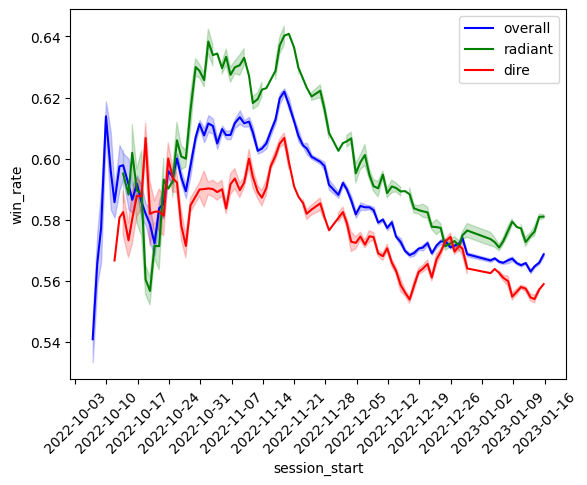

In [8]:
fig, ax = plt.subplots()
wr = df[['session_start', 'win', 'team']].sort_values('session_start', ascending=True).reset_index(drop=True)
wr['win_rate'] = wr['win'].expanding(30).mean()
ax = sns.lineplot(x='session_start', y='win_rate',data=wr, color='blue', label='overall')
wr_session = wr[['session_start', 'win']]
session_wins = wr_session.groupby('session_start').sum()
session_losses = wr_session.groupby('session_start').count() - wr_session.groupby('session_start').sum()
session_losses = session_losses.reset_index().rename(columns={'win': 'loss'})
session_wins = session_wins.merge(session_losses, on='session_start')
print(session_wins)

wr_radiant = df[['session_start', 'win', 'team']].loc[df["team"] == "radiant"].sort_values('session_start', ascending=True).reset_index(drop=True)
wr_radiant['win_rate'] = wr_radiant['win'].expanding(30).mean()
ax = sns.lineplot(x='session_start', y='win_rate',data=wr_radiant, color='green', label='radiant')

wr_dire = df[['session_start', 'win', 'team']].loc[df["team"] == "dire"].sort_values('session_start', ascending=True).reset_index(drop=True)
wr_dire['win_rate'] = wr_dire['win'].expanding(30).mean()
ax = sns.lineplot(x='session_start', y='win_rate',data=wr_dire, color='red', label='dire')

loc = WeekdayLocator(byweekday=MO, interval=1)
ax.xaxis.set_major_locator(loc)
ax = plt.xticks(rotation = 45)


   hero_name    win   start_time_normal       session_start  win_rate  played_to_date
0     Clinkz   True 2022-10-20 18:49:42 2022-10-20 18:49:42       NaN               1
1     Clinkz   True 2022-10-20 20:05:34 2022-10-20 18:49:42       NaN               2
2     Clinkz   True 2022-10-20 21:43:25 2022-10-20 18:49:42  1.000000               3
3     Clinkz  False 2022-10-21 01:04:48 2022-10-20 18:49:42  0.750000               4
4     Clinkz   True 2022-10-21 01:44:18 2022-10-20 18:49:42  0.800000               5
5     Clinkz   True 2022-10-28 19:42:08 2022-10-28 19:42:08  0.833333               6
6     Clinkz   True 2022-10-28 20:40:23 2022-10-28 19:42:08  0.857143               7
7     Clinkz   True 2022-10-28 23:36:34 2022-10-28 19:42:08  0.875000               8
8     Clinkz   True 2022-10-30 20:14:54 2022-10-30 20:14:54  0.888889               9
9     Clinkz  False 2022-10-30 21:23:10 2022-10-30 20:14:54  0.800000              10
10    Clinkz   True 2022-10-31 23:48:42 2022-10-31 20:

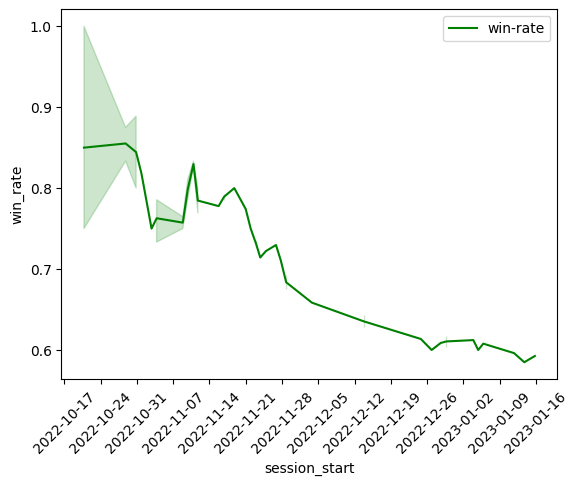

In [9]:
hero_name = 'Clinkz'

df_hero = df[['hero_name', 'win', 'start_time_normal', 'session_start']].loc[df["hero_name"] == hero_name].sort_values('start_time_normal', ascending=True).reset_index(drop=True)
df_hero['win_rate'] = df_hero['win'].expanding(3).mean()
df_hero['played_to_date'] = df_hero.groupby(['hero_name']).cumcount() + 1
print(df_hero)
fig, ax = plt.subplots()
ax = sns.lineplot(x='session_start', y='win_rate',data=df_hero, color='green', label='win-rate')
loc = WeekdayLocator(byweekday=MO, interval=1)
ax.xaxis.set_major_locator(loc)
ax = plt.xticks(rotation = 45)

In [10]:
df = object_as_df(PlayerMatches().query.all())
print(df)

     player_id    match_id  player_slot  radiant_win  duration  game_mode  lobby_type  hero_id  start_time  version  ...  assists  skill  average_rank leaver_status  party_size   start_time_normal  session_id session_counter     team    win
0    849473199  6956963798          128         True      3390         22           7       15  1673055564     21.0  ...       10   None          52.0             0         1.0 2023-01-07 01:39:24         131              11     dire  False
1    849473199  6956935560          131        False      1766         22           7       43  1673053253     21.0  ...       18   None          52.0             0         1.0 2023-01-07 01:00:53         131              10     dire   True
2    849473199  6956893839          128         True      2847         22           7       43  1673049820     21.0  ...        9   None          52.0             0         1.0 2023-01-07 00:03:40         131               9     dire  False
3    849473199  6956848732          